## 모듈 Import

In [33]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
from scipy import interpolate
import warnings
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
warnings.filterwarnings("ignore")
sys.path.append(str(Path(os.getcwd())))

## Path 설정

In [2]:
base_path = Path(os.getcwd()).parent
sys.path.append(base_path)

## 데이터 로딩

In [3]:
water_lst = glob(f'{base_path}/raw_data/water_data/*.csv')
rain_lst = glob(f'{base_path}/raw_data/rf_data/*.csv')

## 데이터 병합

In [4]:
water_lst = glob(f'{base_path}/raw_data/water_data/*.csv')
rain_lst = glob(f'{base_path}/raw_data/rf_data/*.csv')

water_df = pd.DataFrame()
rain_df = pd.DataFrame()
for w in water_lst:
    water_df = water_df.append(pd.read_csv(w))
for r in rain_lst:
    rain_df = rain_df.append(pd.read_csv(r))

## 데이터 명세

In [5]:
# water 데이터 컬럼 설명
"""
ymdhm : 년월일시분
swl : 팔당댐 현재수위 (단위 :El.m)
inf : 팔당댐 유입량 (단위 : m^3/s)
swf : 팔당댐 저수량 (단위 : 만m^3)
ecpc : 팔당댐 공용량 (단위 : 백만m^3)
tototf: 총 방류량 (eksdnl : m^3/s)
tide_level : 강화대교 조위 ( 단위 : cm) # 조위는 조석에 의해 변하는 해수면의 높이
wl_1018662 : 청담대교 수위 ( 단위 : cm)
fw_1018622 : 청담대교 유량 ( 단위 : m^3/s)
(유량은 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타낼 때 쓰는 개념)
wl_1018680 : 잠수교 수위 ( 단위 : cm)
fw_1018680 : 잠수교 유량 ( 단위 : m^3/s)
wl_1018683 : 한강대교 수위 ( 단위 : cm)
fw_1018683 : 한강대교 유량 ( 단위 : m^3/s)
wl_1019630 : 행주대교 수위 ( 단위 : cm)
fw_1019630 : 행주대교 유량 ( 단위 : m^3/s)
"""

# RainFall 데이터 컬럼 설명
"""
YMDHM : 년월일시분
rf_10184100 : 대곡교 강수량(단위 : cm)
rf_10184110 : 진관교 강수량(단위 : cm)
rf_10184140 : 송정동 강수량(단위 : cm)
"""

'\nYMDHM : 년월일시분\nrf_10184100 : 대곡교 강수량(단위 : cm)\nrf_10184110 : 진관교 강수량(단위 : cm)\nrf_10184140 : 송정동 강수량(단위 : cm)\n'

## 데이터 타입 수정

In [6]:
water_df['ymdhm'] = pd.to_datetime(water_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )
rain_df['ymdhm'] = pd.to_datetime(water_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )

In [7]:
merge_df = pd.merge(water_df, rain_df, how = 'left', on = 'ymdhm')

In [8]:
merge_df

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
0,2012-05-01 00:00:00,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18,0.0,0.0,0.0
1,2012-05-01 00:10:00,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18,0.0,0.0,0.0
2,2012-05-01 00:20:00,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18,0.0,0.0,0.0
3,2012-05-01 00:30:00,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17,0.0,0.0,0.0
4,2012-05-01 00:40:00,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10:00,25.040,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,NaN,0.0,-456.41,0.0,974.40,0.0,0.0,0.0
276332,2022-07-18 23:20:00,25.040,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,NaN,0.0,-717.30,0.0,1006.88,0.0,0.0,0.0
276333,2022-07-18 23:30:00,25.040,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,NaN,0.0,-843.37,0.0,1039.90,0.0,0.0,0.0
276334,2022-07-18 23:40:00,25.040,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,NaN,0.0,-1023.37,0.0,1073.46,0.0,0.0,0.0


## 데이터셋 분리(train, valid, test)

In [9]:
# test set: 2022 06 01 ~
train = merge_df[-((merge_df['ymdhm'].dt.year==2022) & (merge_df['ymdhm'].dt.month>=6))].reset_index(drop =True)
test = merge_df[((merge_df['ymdhm'].dt.year==2022) & (merge_df['ymdhm'].dt.month>=6))].reset_index(drop =True)

In [10]:
test.isna().sum()

ymdhm             0
swl              36
inf              36
sfw              36
ecpc             36
tototf           36
tide_level        4
wl_1018662        0
fw_1018662     1216
wl_1018680        0
fw_1018680     6912
wl_1018683        0
fw_1018683        0
wl_1019630        0
fw_1019630        0
rf_10184100       0
rf_10184110       0
rf_10184140       0
dtype: int64

In [11]:
train.isna().sum()

ymdhm               0
swl               707
inf               707
sfw               707
ecpc              707
tototf            707
tide_level       4923
wl_1018662         59
fw_1018662      15164
wl_1018680         59
fw_1018680     189937
wl_1018683         59
fw_1018683       1279
wl_1019630         59
fw_1019630         59
rf_10184100         0
rf_10184110         0
rf_10184140         0
dtype: int64

- 테스트 데이터의 강화대교와 잠수교의 유량이 결측값으로 존재 이러한 경우 유량이 예측에 중요 변수일경우 예측정확도 감소
- 유량의 결측값을 팔당댐의 방류와 강수량 데이터 그리고 다른 대교들의 유량데이터를 통해 보간할 수 있지않을까?? 
- 팔당댐의 현재수위, 유입량, 저수량, 공용량은 시계열이기때문에 t-n시점의 데이터와 강수량등등으로 유추할 수 있지않을까??(증발고려하기)

## 데이터 보간(Interpolation)

- 팔당댐 보간 -> 팔당댐 데이터로 대교 유량 보간

### 팔당댐 현재수위 

<AxesSubplot:xlabel='ymdhm', ylabel='swl'>

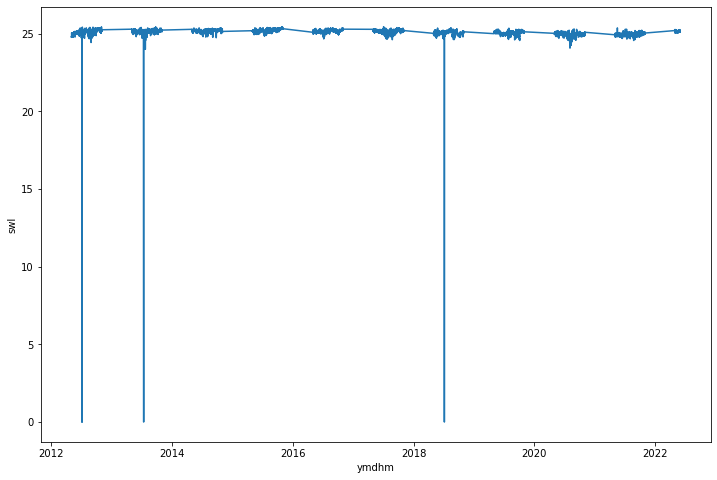

In [34]:
plt.figure(figsize = (12,8))
sns.lineplot(train['ymdhm'], train['swl'])

In [35]:
train['swl'].min()

0.0

- 수위가 0인 데이터가 있다는것이 확인되었고, 이것이 진실된것인지 오류값인지 확인해보자

In [29]:
list(train[train['swl']==0]['ymdhm'])

[Timestamp('2012-07-02 21:00:00'),
 Timestamp('2012-07-02 22:00:00'),
 Timestamp('2012-07-02 23:00:00'),
 Timestamp('2012-07-03 00:00:00'),
 Timestamp('2012-07-03 01:00:00'),
 Timestamp('2012-07-03 02:00:00'),
 Timestamp('2012-07-03 03:00:00'),
 Timestamp('2012-07-03 04:00:00'),
 Timestamp('2012-07-03 05:00:00'),
 Timestamp('2012-07-03 06:00:00'),
 Timestamp('2012-07-03 07:00:00'),
 Timestamp('2012-07-03 08:00:00'),
 Timestamp('2012-07-04 21:40:00'),
 Timestamp('2012-07-04 21:50:00'),
 Timestamp('2012-07-04 22:10:00'),
 Timestamp('2012-07-04 22:20:00'),
 Timestamp('2012-07-04 22:30:00'),
 Timestamp('2012-07-04 22:40:00'),
 Timestamp('2012-07-04 22:50:00'),
 Timestamp('2012-07-04 23:10:00'),
 Timestamp('2012-07-04 23:20:00'),
 Timestamp('2012-07-04 23:30:00'),
 Timestamp('2012-07-04 23:40:00'),
 Timestamp('2012-07-04 23:50:00'),
 Timestamp('2012-07-05 00:10:00'),
 Timestamp('2012-07-05 00:20:00'),
 Timestamp('2012-07-05 00:30:00'),
 Timestamp('2012-07-05 00:40:00'),
 Timestamp('2012-07-

In [39]:
train.iloc[9055]

ymdhm          2012-07-02 21:10:00
swl                         25.199
inf                          245.3
sfw                         233.19
ecpc                         10.81
tototf                       245.3
tide_level                   228.0
wl_1018662                   307.7
fw_1018662                  447.93
wl_1018680                   306.2
fw_1018680                     0.0
wl_1018683                   297.0
fw_1018683                  840.67
wl_1019630                   284.3
fw_1019630                  652.89
rf_10184100                    0.0
rf_10184110                    0.0
rf_10184140                    0.0
Name: 9055, dtype: object

In [41]:
train.iloc[9053]

ymdhm          2012-07-02 20:50:00
swl                         25.206
inf                          245.2
sfw                         233.45
ecpc                         10.55
tototf                       245.2
tide_level                   251.0
wl_1018662                   320.7
fw_1018662                   543.1
wl_1018680                   314.2
fw_1018680                     0.0
wl_1018683                   303.0
fw_1018683                 1115.28
wl_1019630                   284.3
fw_1019630                  652.89
rf_10184100                    0.0
rf_10184110                    0.0
rf_10184140                    0.0
Name: 9053, dtype: object

In [42]:
train.iloc[9059]

ymdhm          2012-07-02 21:50:00
swl                          25.21
inf                          351.3
sfw                         233.58
ecpc                         10.42
tototf                       251.3
tide_level                   186.0
wl_1018662                   300.7
fw_1018662                  400.58
wl_1018680                   300.2
fw_1018680                     0.0
wl_1018683                   291.0
fw_1018683                  379.71
wl_1019630                   280.3
fw_1019630                  601.45
rf_10184100                    0.0
rf_10184110                    0.0
rf_10184140                    0.0
Name: 9059, dtype: object

In [36]:
train[train['swl']==0]

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
9054,2012-07-02 21:00:00,0.0,0.0,0.00,244.00,0.0,240.0,311.7,476.21,310.2,0.0,299.0,1010.22,284.3,652.89,0.0,0.0,0.0
9060,2012-07-02 22:00:00,0.0,0.0,0.00,244.00,0.0,176.0,301.7,407.18,299.2,0.0,290.0,326.94,277.3,564.29,0.0,0.0,0.0
9066,2012-07-02 23:00:00,0.0,0.0,0.00,244.00,0.0,122.0,300.7,400.58,294.2,0.0,283.0,590.88,266.3,438.33,0.0,0.0,0.0
9072,2012-07-03 00:00:00,0.0,0.0,0.00,244.00,0.0,80.0,295.7,368.42,285.2,0.0,277.0,306.19,268.3,460.03,0.0,0.0,0.0
9078,2012-07-03 01:00:00,0.0,0.0,0.00,244.00,0.0,158.0,297.7,381.12,286.2,0.0,276.0,184.79,263.3,406.79,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36888,2013-07-12 04:00:00,0.0,0.0,0.00,244.00,0.0,195.0,405.7,1400.11,379.2,0.0,369.0,2252.24,343.3,1663.48,0.0,0.0,0.0
36894,2013-07-12 05:00:00,0.0,0.0,0.00,244.00,0.0,290.0,402.7,1362.85,374.2,0.0,365.0,2212.95,340.3,1600.64,0.0,0.0,0.0
36900,2013-07-12 06:00:00,0.0,0.0,0.00,244.00,0.0,464.0,399.7,1326.12,372.2,0.0,362.0,2144.56,338.3,1559.43,0.0,0.0,0.0
36906,2013-07-12 07:00:00,0.0,0.0,0.00,244.00,0.0,631.0,396.7,1289.90,370.2,0.0,360.0,2171.14,335.3,1498.64,0.0,0.0,0.0


### 팔당댐 유입량

<AxesSubplot:xlabel='ymdhm', ylabel='inf'>

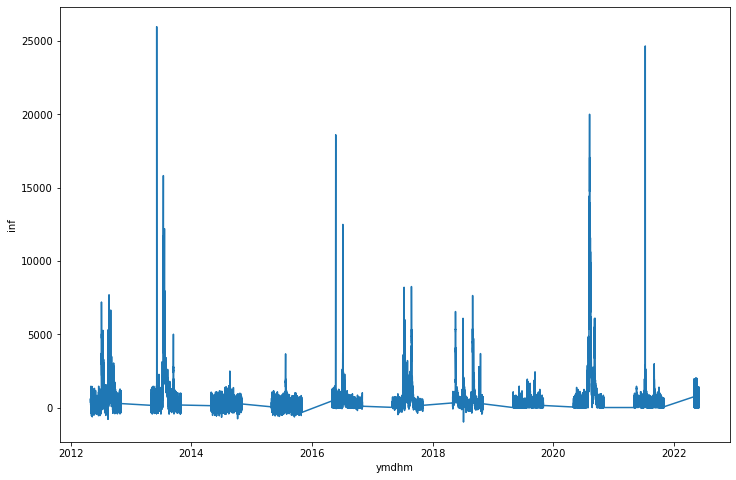

In [38]:
plt.figure(figsize = (12,8))
sns.lineplot(train['ymdhm'], train['inf'])

### 팔당댐 저수량

### 팔당댐 공용량

### 팔당댐 총 방류량